# ***
The following code is in the big part based on the tutorial from https://nextjournal.com/gkoehler/pytorch-mnist. Although I did make several improvements and simplifications, my greatest feat is just understanding everything, what's going on below.

The objective was to train CNN to recognize digits from classic MNIST dataset. I achieved accuracy of 99% after 3 epochs.
# ***

In [1]:
# modules

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# download data and transform images to tensor

batch_size_train = 64
batch_size_test = 64

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True, transform=torchvision.transforms.ToTensor()),
    batch_size=batch_size_train, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True, transform=torchvision.transforms.ToTensor()),
    batch_size=batch_size_test, 
    shuffle=True)

# one can think of loaders as of iterators of tuples (batches), which consist of another tuples (tensored image, label)

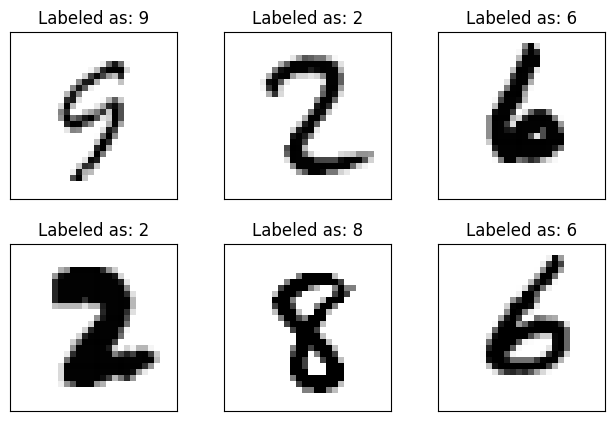

In [3]:
# what have we downloaded

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# plotting

for i in range(6):
  plt.subplot(2, 3, i + 1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap = 'gray_r', interpolation = 'none')
  plt.title("Labeled as: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [4]:
# we create the net

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x) # it basically transforms output to probability distribution

In [5]:
# initiate net and optimizer

model = Net()
learning_rate = 0.003
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [6]:
# GPU

if  torch.cuda.is_available():
    current_device = torch.device("cuda")
    print("CUDA ready to action.")

else:
    current_device = torch.device("cpu")
    print("CUDA unavailable :(. Using CPU instead.")

# changing to CUDA

model = model.to(device = current_device)

CUDA ready to action.


In [7]:
# learning loop

train_losses = []
train_counter = []
test_losses = []

def train(epoch):

  for batch_index, (data, target) in enumerate(train_loader):

    # change device where data is stored

    data = data.to(device = current_device)
    target = target.to(device = current_device)

    # single step

    optimizer.zero_grad()               # clear gradient
    output = model(data)                # calculate predictions
    loss = F.nll_loss(output, target)   # calculate loss (error) with negative likelihood loss function
    loss.backward()                     # calculate gradient of loss with respect to weights
    optimizer.step()                    # update weigths

    # save losses and optionally print progress bar

    print_time = 50

    if batch_index % print_time == 0:
      
      '''
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_index * len(data), len(train_loader.dataset),
        100. * batch_index / len(train_loader), loss.item()))
      '''
      
      train_losses.append(loss.item())                            # list of losses
      train_counter.append(
        (batch_index*64) + ((epoch-1)*len(train_loader.dataset))) # corresponding list showing number of images used to train

In [8]:
# test function

accuracy_list = []

def test():

  test_loss = 0
  correct = 0

  for data, target in test_loader:

    # change device where data is stored

    data = data.to(device = current_device)   
    target = target.to(device = current_device)
    
    # calculate model predictions

    output = model(data)
    test_loss += F.nll_loss(output, target, size_average=False).item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()

  # collect data for statistics

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  accuracy = correct / len(test_loader.dataset)
  accuracy = accuracy.cpu().numpy()
  accuracy_list.append(accuracy)
  print('\nTest results: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100 * accuracy))

In [9]:
# training

n_epochs = 3

test()  
for epoch in range(1, n_epochs + 1):
  train(epoch)
  print("%i epoch(s) passed." %epoch)
  test()

C:\Users\rewas\AppData\Local\Temp\ipykernel_15588\2170415608.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # it basically transforms output to probability distribution
d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test results: Avg. loss: 2.3054, Accuracy: 1129/10000 (11%)

1 epoch(s) passed.

Test results: Avg. loss: 0.0565, Accuracy: 9825/10000 (98%)

2 epoch(s) passed.

Test results: Avg. loss: 0.0489, Accuracy: 9844/10000 (98%)

3 epoch(s) passed.

Test results: Avg. loss: 0.0504, Accuracy: 9837/10000 (98%)



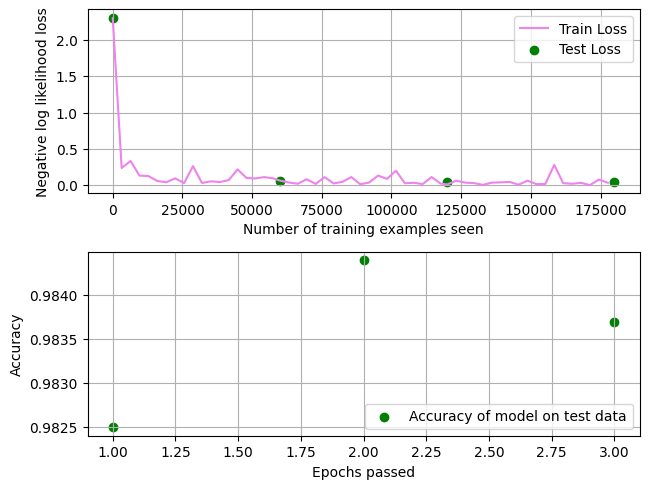

In [10]:
# plot loss and accuracy

plt.subplot(2, 1, 1)

plt.plot(train_counter, train_losses, color = 'violet')
plt.scatter(6e+04*np.array((range(n_epochs+1))), test_losses, color = 'green')
plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
plt.tight_layout()
plt.grid()
plt.xlabel('Number of training examples seen')
plt.ylabel('Negative log likelihood loss')

plt.subplot(2, 1, 2)

plt.scatter(range(1, len(accuracy_list)), accuracy_list[1: ], color = "green")
plt.grid()
plt.tight_layout()
plt.ylabel("Accuracy")
plt.xlabel("Epochs passed")
plt.legend(["Accuracy of model on test data"], loc = "lower right")

plt.show()

C:\Users\rewas\AppData\Local\Temp\ipykernel_15588\2170415608.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # it basically transforms output to probability distribution


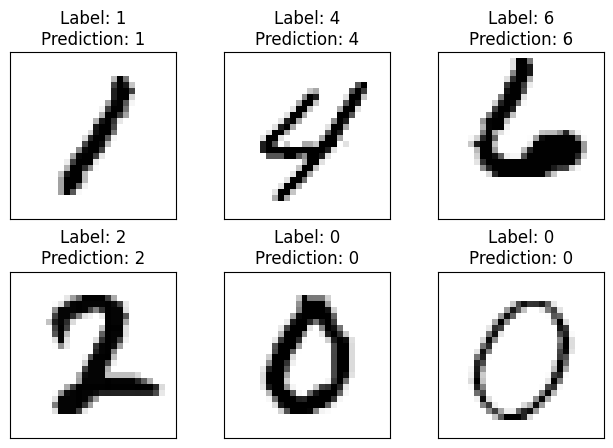

In [11]:
# predictions of model

batch_idx, (example_data, example_targets) = next(examples)     # choose one batch of images and labels
example_data = example_data.to(device = current_device)         # transport them on gpu
output = model(example_data)                                    # make predictions
example_data = example_data.cpu()                               # re-transport them on cpu

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray_r', interpolation='none')
  plt.title("Label: {label}\nPrediction: {pred}".format(
    label = example_targets[i].item(),
    pred = output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()